In [1]:


# Cell 1: 基础导入 & 加载配置
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.exp_config import get_config
from data_provider.data_loader import DataModule
from exp.exp_model import Model

# ==== 选择配置 ====

config = get_config('LZHModelConfig')
config.model = 'lzhmodel'
config.diff=1
# 只展示一个批次的第1个数据变化方式
config.bs = 1
config.diff = 1

# 用 GPU / CPU
device = config.device
print("Using device:", device)



<module 'module.name' from 'configs/LZHModelConfig.py'> LZHModelConfig
Using device: cuda


In [2]:


# Cell 2: 构建 DataModule & 加载模型权重

# log是为了用dataLoader占位用的
class DummyLogger:
    def only_print(self, msg):
        print(msg)

config.log = DummyLogger()

# 构建 DataModule（会自动 load_data + 切分 + DataLoader）
datamodule = DataModule(config)

# 构建 LZHModel（是被 BasicModel 包了一层的 Model）
model = Model(config).to(device)
model.eval()

# ==== 加载训练好的权重 ====
# 路径规则和 RunOnce 里是一样的：
model_ckpt = "./checkpoints/lzhmodel/Datasetweather_Modellzhmodel_Density0.700_dmodel128_Rank40_diff1_SeqLen96_PredLen96_NoiseSteps40_NoiseScale1.0_Lamda0.5_round_0.pt"  # TODO: 改成你真实的路径

state_dict = torch.load(model_ckpt, map_location=device)
model.load_state_dict(state_dict)
print("Loaded checkpoint from:", model_ckpt)



Train_length : 36696 Valid_length : 5078 Test_length : 10349
[DEBUG] LZHModel __init__ got diff = 1
[DEBUG] LZHModel __init__ got diff = True
Loaded checkpoint from: ./checkpoints/lzhmodel/Datasetweather_Modellzhmodel_Density0.700_dmodel128_Rank40_diff1_SeqLen96_PredLen96_NoiseSteps40_NoiseScale1.0_Lamda0.5_round_0.pt


In [3]:


# Cell 3: 取一个 batch，计算 x_hat 和 y_hat

# 从 test_loader 里取一个 batch（因为 shuffle=False，可理解为“第一个样本”）
test_batch = next(iter(datamodule.test_loader))
# weather: x, x_mark, y
x, x_mark, y = [t.to(device) for t in test_batch]

print("x shape:", x.shape)        # [B, seq_len, C_x]
print("x_mark shape:", x_mark.shape)
print("y shape:", y.shape)        # [B, pred_len, C_y]

with torch.no_grad():
    # 1) 通过 diffusion_forward 得到 x_hat
    x_hat = model.model.diffusion_forward(x)
    
    # 2) 正常前向得到 y_hat
    outputs = model(x, x_mark)
    if isinstance(outputs, tuple):
        y_hat, _ = outputs   # (pred, dcs_loss)
    else:
        y_hat = outputs

print("x_hat shape:", x_hat.shape)
print("y_hat shape:", y_hat.shape)

x shape: torch.Size([1, 96, 21])
x_mark shape: torch.Size([1, 96, 4])
y shape: torch.Size([1, 96, 21])
x_hat shape: torch.Size([1, 96, 21])
y_hat shape: torch.Size([1, 96, 21])


In [4]:
print("model1.model.use_diff =", model.model.use_diff)

model1.model.use_diff = True


Figure saved to: ./resultsPNG/figures\lzhmodel_diffusion_weather_all_features_20251201-230016.png


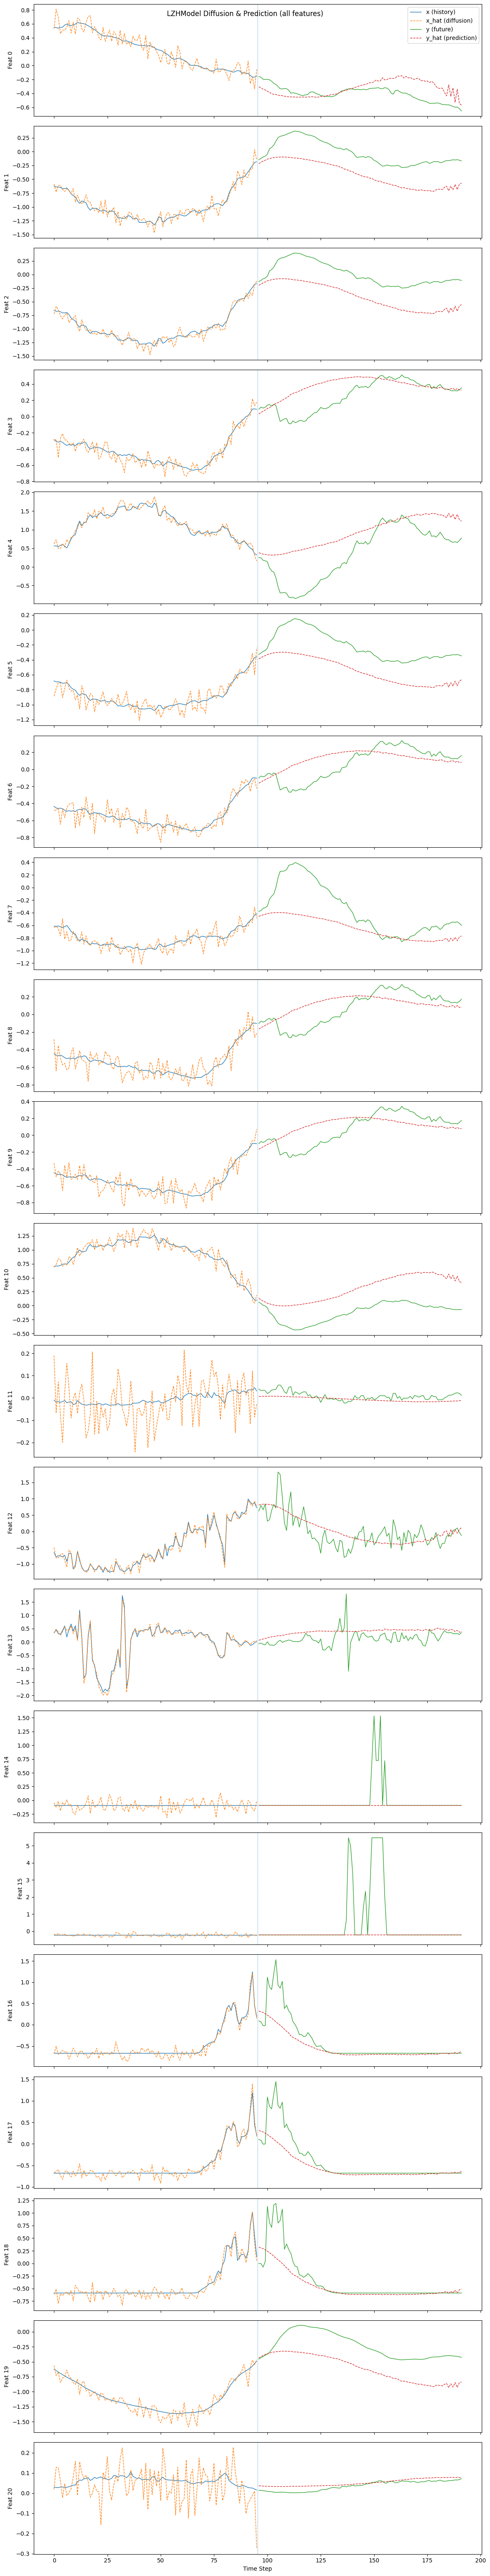

In [5]:
# 替换原来的 Cell 4: 抽取 batch[0] 的全部通道并可视化 + 保存图片（带时间戳）
import os
from datetime import datetime

# 把 tensor -> numpy
x_np     = x[0].detach().cpu().numpy()        # [seq_len, C_x]
x_hat_np = x_hat[0].detach().cpu().numpy()    # [seq_len, C_x]
y_np     = y[0].detach().cpu().numpy()        # [pred_len, C_y]
y_hat_np = y_hat[0].detach().cpu().numpy()    # [pred_len, C_y]

seq_len   = x_np.shape[0]
pred_len  = y_np.shape[0]
num_feat  = x_np.shape[1]

t_hist   = np.arange(seq_len)
t_future = np.arange(seq_len, seq_len + pred_len)

# 一张图里多个子图：每个特征一个子图
fig, axes = plt.subplots(num_feat, 1, figsize=(12, 3 * num_feat), sharex=True)

# 兼容 num_feat == 1 的情况
if num_feat == 1:
    axes = [axes]

for c in range(num_feat):
    ax = axes[c]

    x_c     = x_np[:, c]
    x_hat_c = x_hat_np[:, c]
    y_c     = y_np[:, c]
    y_hat_c = y_hat_np[:, c]

    # 历史部分：t = [0, seq_len-1]
    ax.plot(t_hist, x_c, label='x (history)', linewidth=1)
    ax.plot(t_hist, x_hat_c, linestyle='--', label='x_hat (diffusion)', linewidth=1)

    # 未来部分：t = [seq_len, seq_len+pred_len-1]
    ax.plot(t_future, y_c, label='y (future)', linewidth=1)
    ax.plot(t_future, y_hat_c, linestyle='--', label='y_hat (prediction)', linewidth=1)

    # 一条竖线标记历史/未来分界
    ax.axvline(seq_len - 0.5, linestyle=':', linewidth=0.8)

    ax.set_ylabel(f'Feat {c}')
    if c == 0:
        ax.legend(loc='upper right')

axes[-1].set_xlabel('Time Step')
fig.suptitle('LZHModel Diffusion & Prediction (all features)', y=0.99)

plt.tight_layout()

# ===== 保存图片（文件名带时间戳）=====
save_dir = './resultsPNG/figures'
os.makedirs(save_dir, exist_ok=True)

# 生成时间戳，比如 20251201-231530
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f'lzhmodel_diffusion_weather_all_features_{timestamp}.png'
save_path = os.path.join(save_dir, filename)

plt.savefig(save_path, dpi=300)
print('Figure saved to:', save_path)

plt.show()

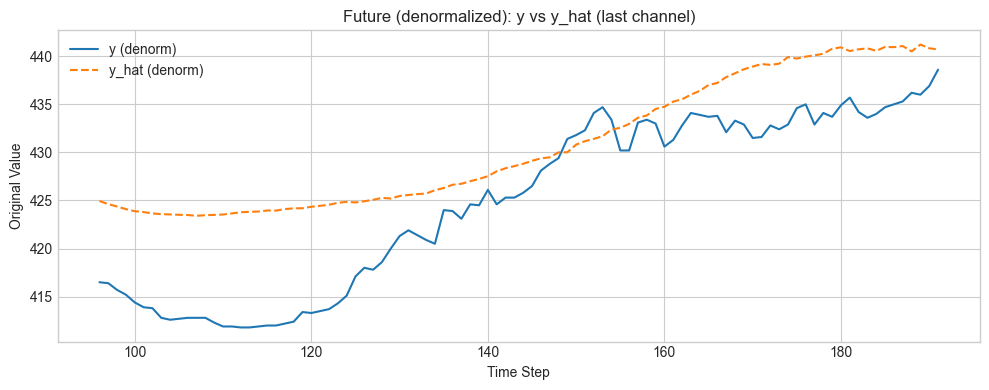

In [20]:
# Cell 5: 可选 - 把 y / y_hat 反归一化到原始数值再画

# 注意：y_scaler 是在 get_ts 里对所有通道一起 fit 的
y_denorm = datamodule.y_scaler.inverse_transform(y_np)
y_hat_denorm = datamodule.y_scaler.inverse_transform(y_hat_np)

y_last_denorm     = y_denorm[:, -1]
y_hat_last_denorm = y_hat_denorm[:, -1]

plt.figure(figsize=(10, 4))
plt.plot(t_future, y_last_denorm, label='y (denorm)')
plt.plot(t_future, y_hat_last_denorm, linestyle='--', label='y_hat (denorm)')
plt.legend()
plt.title('Future (denormalized): y vs y_hat (last channel)')
plt.xlabel('Time Step')
plt.ylabel('Original Value')
plt.tight_layout()
plt.show()
